In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import copy
from keras.models import load_model
from keras.models import Sequential
import math

C:\Users\Nathan\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# -------------------------------------------------
# Constant
SIZE_FILTER_X = 36
SIZE_FILTER_Y = 36
NB_ITERATION = 40

In [3]:
def load_model_keras(path_to_model):
    return load_model(path_to_model)

In [4]:
def compute_mean_rectangle(list_point, step_x, step_y):
    has_changed = True
    while(has_changed):
        has_changed = False
        temp_result = []
        list_indice = []
        for i in range(len(list_point)):
            Added_new_element = False
            for j in range(i+1, len(list_point)):
                if (math.fabs(list_point[i][0] - list_point[j][0]) <= 3*step_x and
                    math.fabs(list_point[i][1] - list_point[j][1]) <= 3*step_y and j not in list_indice):
                    
                    temp_result.append((int((list_point[i][0] + list_point[j][0])/2), int((list_point[i][1] + list_point[j][1])/2)))
                    list_indice.append(j)
                    Added_new_element = True
                    
            if Added_new_element == False and i not in list_indice:
                temp_result.append(list_point[i])
                
            has_changed = has_changed | Added_new_element
            
        list_point = copy.deepcopy(temp_result)
    
    return list_point
        

In [5]:
def compute_highest_score(list_point, list_score, step_x, step_y, mode):
    
    ## Mode
    # 1 : Locally
    # 2 : Highest score on the entire image.
    
    if(mode == 1) : 
    
        has_changed = True
        while(has_changed):
            has_changed = False
            temp_result = []
            list_indice = []
            for i in range(len(list_point)):
                Added_new_element = False
                for j in range(i+1, len(list_point)):
                    if (math.fabs(list_point[i][0] - list_point[j][0]) <= 3*step_x and
                        math.fabs(list_point[i][1] - list_point[j][1]) <= 3*step_y and j not in list_indice):

                        index_max_score = list_score.index(max([list_score[i],list_score[j]]))
                        temp_result.append((list_point[index_max_score][0], list_point[index_max_score][1]))
                        list_indice.append(j)
                        Added_new_element = True

                if Added_new_element == False and i not in list_indice:
                    temp_result.append(list_point[i])

                has_changed = has_changed | Added_new_element

            list_point = copy.deepcopy(temp_result)

        return list_point
    
    elif(mode == 2) :
      
        pos_max_score = []

        if(list_score) :
            index_max_score = list_score.index(max(list_score))
            pos_max_score.append((list_point[index_max_score][0], list_point[index_max_score][1]))
            
        return pos_max_score
    
    
    

In [6]:
def search_visage(gray_image, size_filter_X, size_filter_Y, model):
    
    # Raise an exception, if we can't apply the fitlter
    width, height = gray_image.shape[0], gray_image.shape[1]
    
    if width < size_filter_Y and height < size_filter_X :
        raise Exception ("impossible to crop properly")
        
    if (size_filter_X/2) % 2 != 0 or (size_filter_Y/2) % 2 != 0:
        raise Exception ("All dimension of the filter should be pair")
    
    # loop on the image.
    fil_divi_2_X = int (size_filter_X/2)
    fil_divi_2_Y = int (size_filter_Y/2)
    step_x = int(fil_divi_2_X/3)
    step_y = int(fil_divi_2_Y/3)
    result = []
    listImgPos = []
    listScorePos = []
    for y in range(fil_divi_2_X, height - fil_divi_2_X, step_x):
        for x in range(fil_divi_2_Y, width - fil_divi_2_Y, step_y):
            crop_img = gray_image[y - fil_divi_2_Y: y + fil_divi_2_Y, x - fil_divi_2_X : x + fil_divi_2_X]
            
            crop_imag_copy  = copy.deepcopy(crop_img)
            
            crop_img = np.array(crop_img)
            crop_img.resize((1,36,36,1))
            
            score = model.predict(crop_img,verbose = 0)[0]
            if int(score + 0.01) == 1:
                #print ("GET A VISAGE")
                result.append((x,y))
                listScorePos.append(score)
                listImgPos.append(crop_imag_copy)
                
    #return compute_mean_rectangle(result, step_x, step_y), listImgPos
    return compute_highest_score(result, listScorePos, step_x, step_y, 1), listImgPos

In [7]:
def draw_rectangle(img, cor_x, cor_y, size_filter_X, size_filter_Y ):
    fil_divi_2_X = int (size_filter_X/2)
    fil_divi_2_Y = int (size_filter_Y/2)
    cv2.rectangle(img, (cor_x - fil_divi_2_X, cor_y - fil_divi_2_Y), (cor_x + fil_divi_2_X, cor_y + fil_divi_2_Y), (255,0,0), 2)
    return img

In [8]:
def pyramid_search (path_image, size_filter_X, size_filter_Y, nb_iterations, model):
    # We get and tranform the image in gray.
    img_search = cv2.imread(path_image)
    gray_image = cv2.cvtColor(img_search, cv2.COLOR_BGR2GRAY)
    gray_imag_rect  = copy.deepcopy(gray_image)
    
    # Make the reduction.
    height, width = gray_image.shape
    nbPixelToReduceX = int(int(width  - size_filter_X) / (nb_iterations-1))
    nbPixelToReduceY = int(int(height - size_filter_Y) / (nb_iterations-1))
    
    
    for ite in range(nb_iterations) :
        
        height, width = gray_image.shape
        
        if(ite == nb_iterations-1):
            gray_image = cv2.resize(gray_image, (size_filter_X, size_filter_Y)) # Last iteration
            size_filter_X_new = width - nbPixelToReduceX
            size_filter_Y_new = height - nbPixelToReduceY
            height, width = gray_image.shape
        elif(ite == 0):
            size_filter_X_new = size_filter_X - nbPixelToReduceX
            size_filter_Y_new = size_filter_Y - nbPixelToReduceY
        else :
            gray_image = cv2.resize(gray_image, (width - nbPixelToReduceX, height - nbPixelToReduceY))   
        
        gray_imag_rect_copy  = copy.deepcopy(gray_image)
            
        # we get all square that seems to be a visage.
        result, listImgPos = search_visage(gray_image, size_filter_X, size_filter_Y, model)
        
        size_filter_X_new = nbPixelToReduceX + size_filter_X_new
        size_filter_Y_new = nbPixelToReduceY + size_filter_Y_new
        
        
        # draw red rectangle.
        for x, y in result: 
            gray_imag_rect = draw_rectangle(gray_image, x, y, size_filter_X, size_filter_Y)
        
        
        ## Display positives images
        #for l in listImgPos :
        #    plt.figure()
        #    plt.imshow(l)
            
        ## Display initial image with reds rectangles. 
        if(result == []) :
            plt.figure()
            plt.imshow(gray_image)
        else :
            plt.figure()
            plt.imshow(gray_imag_rect)
        
        # Remove rectangle before next iteration.
        gray_image = gray_imag_rect_copy       
        
    return gray_imag_rect

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE


C:\Users\Nathan\Anaconda3\envs\py35\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE
ADD RECTANGLE


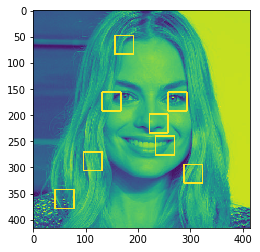

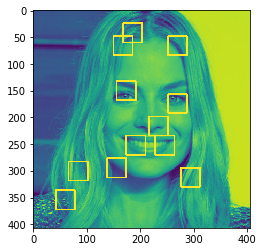

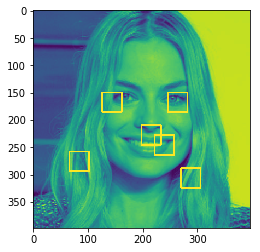

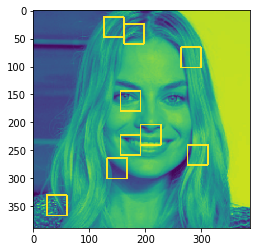

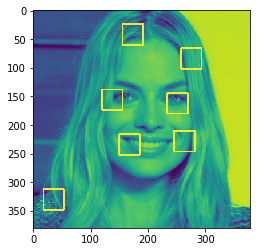

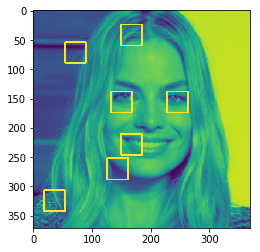

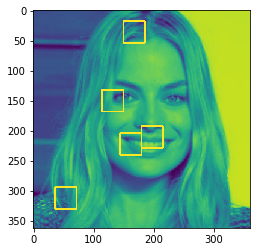

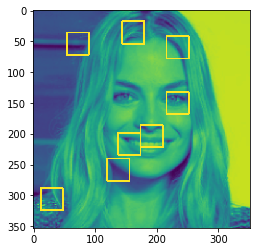

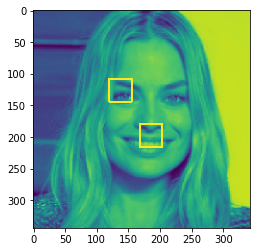

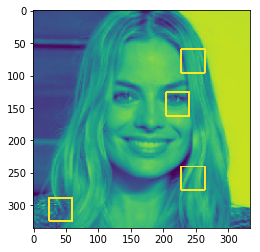

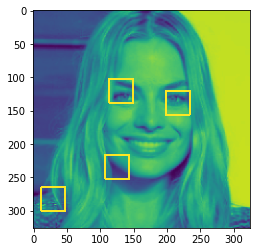

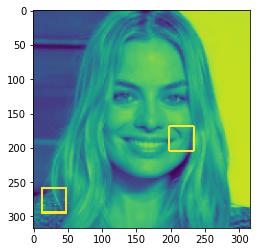

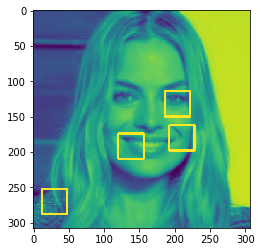

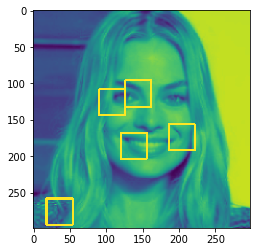

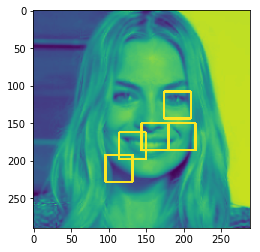

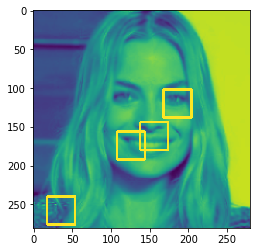

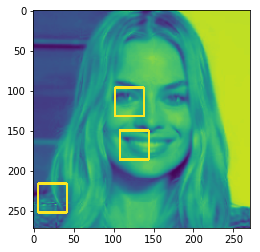

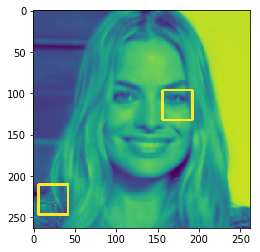

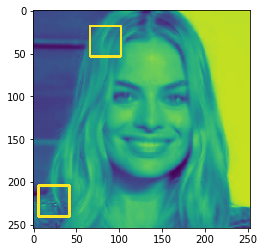

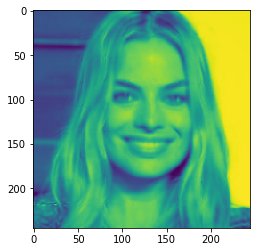

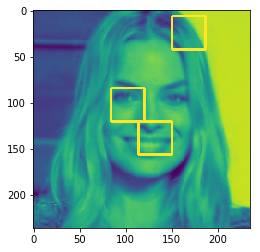

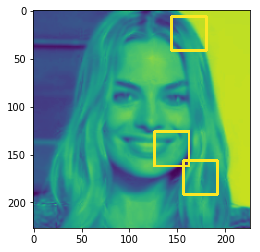

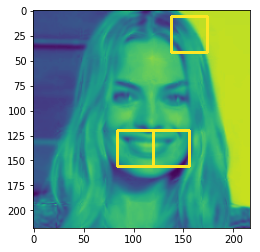

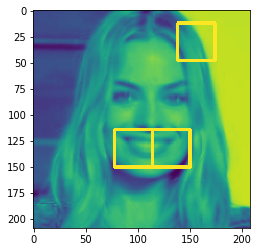

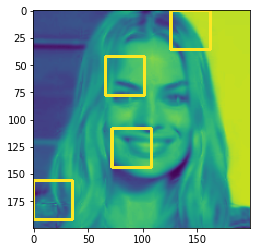

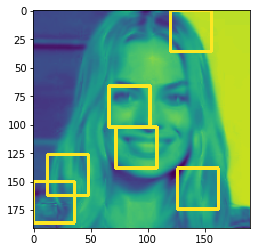

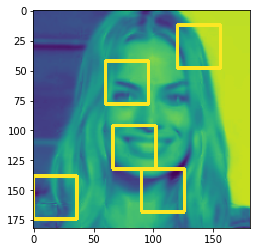

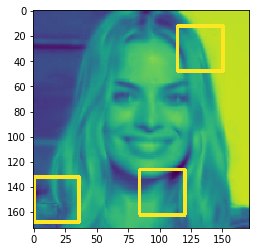

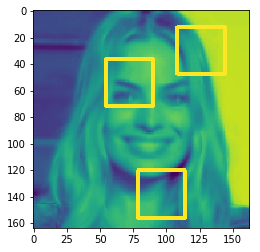

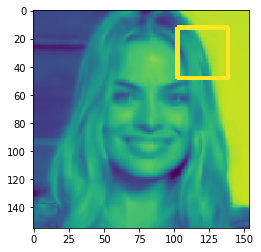

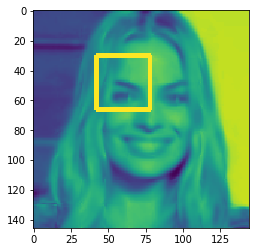

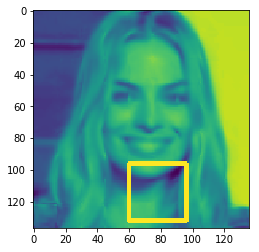

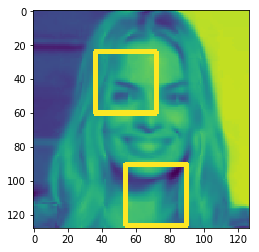

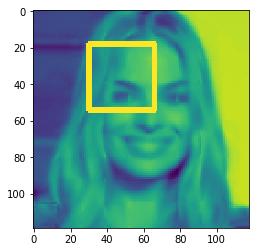

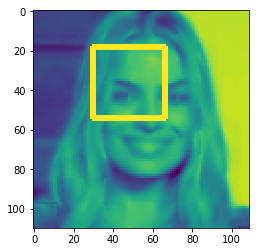

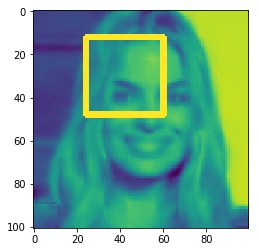

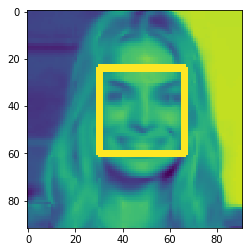

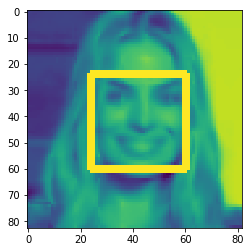

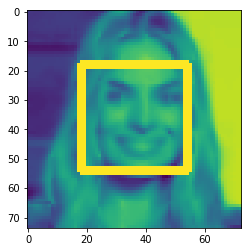

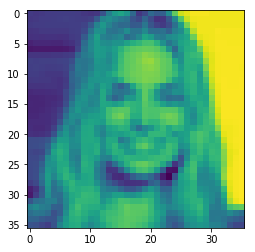

In [9]:
model = load_model_keras('my_model.h5')
result = pyramid_search('hulk.jpg', SIZE_FILTER_X, SIZE_FILTER_Y, NB_ITERATION, model)

In [10]:
#plt.imshow(result, cmap='gray')